In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import numpy as np
import uproot
import hist
from functions import *
NanoAODSchema.warn_missing_crossrefs = False
hep.style.use('CMS')

In [2]:
fname = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/ForHiggsTo4Leptons/Run2012B_DoubleElectron.root'

In [12]:
# Setting entry_stop=50000 will use the first 50000 events, this will make it run faster when trobuleshooting.
allEvents = 1
if allEvents == 1: numEvents = None
else: numEvents = 50000
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema.v6, entry_stop=numEvents).events()

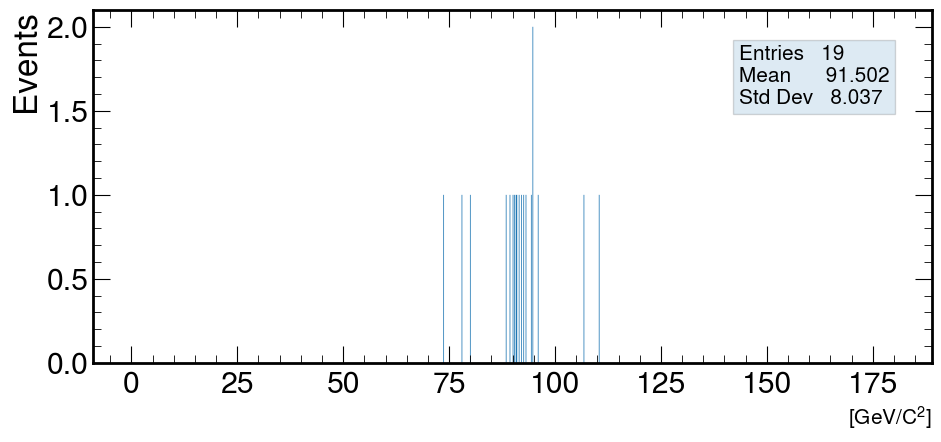

In [4]:
selectedLeptons = ChargeOrdering(LeptonSelectionForZBoson(events, 30, 0, 'Electron'))
h1 = InvariantMassHist(selectedLeptons,1000)
cmsPlot(h1)